# Sentiment Analysis with a simple perceptron 

## Imports

In [3]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [4]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
       
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx         # _token_to_idx: {'<UNK>':0, 'apple':1, 'banana':2, ....., 'zzz':10000}
                                                  # _idx_to_token: {0:'<UNK>', 1:'apple', 2:'banana', ....., 10000:'zzz'}

        self._idx_to_token = {idx: token          
                              for token, idx in self._token_to_idx.items()} 
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
       
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
       
        return cls(**contents)   

    def add_token(self, token):
       
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
       
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
       
        if self.unk_index >= 0:                   # if unk_token is defined, unknown words are handled
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
       
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [5]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
       
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        if isinstance(review, str):
            for token in review.split(" "):
                if token not in string.punctuation:
                    one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
       
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            print(review)
            if isinstance(review, str):
                for word in review.split(" "):
                        if word not in string.punctuation:
                            word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
       
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
       
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

### The Dataset

In [6]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
       
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv, frequency_cutoff):
       
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df, frequency_cutoff))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
       
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
       
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
       
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
       
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=False, device="cpu"):
   
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: ReviewClassifier

In [7]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=1)
       

    def forward(self, x_in, apply_sigmoid=False):
       
        y_out = self.fc1(x_in).squeeze()
        
        # When you added 2 additional hidden layers:
        #intermediate = F.relu(self.fc1(x_in))
        #intermediate = F.relu(self.fc2(intermediate))
        #y_out = self.fc3(intermediate).squeeze()
        
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

## Training Routine

### Helper functions

In [8]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # item() to get a Python number from a tensor containing a single value
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [9]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [10]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    #frequency_cutoff=0,
    model_state_file='model.pth',
    review_csv='data/rt-polaritydata/reviews_with_splits_lite1.csv',
    save_dir='model_storage/ch3/yelp/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.01,
    num_epochs=100,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs ; creat dirs if they don't exist
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch3/yelp/vectorizer.json
	model_storage/ch3/yelp/model.pth
Using CUDA: False


### Initializations

In [11]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv, args.frequency_cutoff)
    dataset.save_vectorizer(args.vectorizer_file)    

vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer
slender plot feel especially thin stretched nearly minute running time 
complete lack originality cleverness even visible effort 
admirable rigor jimmy relentless anger script refusal happy ending monologue stretch realize place story 
group self absorbed woman mother daughter featured film think nothing wrong performance whiney character bugged 
really bad much distasteful need kidnapping suspense drama right like need doomsday thriller 
low budget full frontal one year murkiest intentionally obscure self indulgent picture solaris big budget brother 
proof thriller sleekly shot expertly cast paced crisp professionalism still letdown twist turn hold surprise yesterday weather report 
pitch expectation time low could worse oddly cheerful particularly funny body switching farce 
unless bob crane someone particular interest film impressive performance adept direction likely leave lasting impression 
big loud bang drum bore 
film contains good joke g

predominantly amateur cast painful watch stilted unconvincing performance 
number patient doctor pic cover usual ground 
string rehashed sight gag based insipid vulgarity 
anemic pretentious 
little weak funny 
chan stunt limited embellished editing really much sense action even action comedy 
collapse taylor try shift tone thriller rush 
uplifting largely bogus story 
original gangster sweating bullet worrying contract life 
worst film year 
rate effort boring 
end movie bog insignificance saying nothing kennedy assassination revealing nothing pathology pretend investigate 
yes suppose lovely cal work issue dad come term picture perfect life world traveler gave reason care 
kid bratty sympathy film grows finale little change ring hollow 
era soprano feel painfully redundant inauthentic 
actor forced grapple hazy motivation never come focus 
die another day intermittently entertaining hard sucker charm perhaps impossible feel nostalgia movie grew 
nijinsky say know suffer see film know

laddish juvenile teenage boy could possibly find funny 
flashy pretentious impenetrable morvern thick working class scottish accent 
stagger flaccid satire supposed madcap farce 
wish could say thank god friday truth matter glad 
long winded stagy session romantic contrivance never really gel like shrewd feminist fairy tale could 
sensuality eroticism good vampire tale pardon pun sucked replaced goth goofiness 
audience figure said filmmaker relative passivity make tough really care 
thing break new ground tread old turf like hippopotamus ballerina 
excessive profane packed cartoonish violence comic strip character 
earth anywhere else director ron underwood manage blow million 
debut effort project greenlight winner sappy amateurish 
viewing underdramatized overstated film like watching transcript therapy session brought humdrum life freudian puppet 
really renting interested discretion entertainment choice interested anne geddes john grisham thomas kincaid 
clash artificial structure

ethan hawke always fancied bastard child beatnik generation chelsea wall 
watching movie made released weak unearthed released become even weaker 
story fails rise disgusting source material 
barely get ground 
cast portrays cartoon counterpart well quite frankly scoob shag eat enough film 
wobbly senegalese updating carmen best stunning star turn djeinaba diop gai 
get old quickly watch barbershop need cube fix worth sitting 
end film feel homogenized bit contrived looking back tattered ugly past rose tinted glass 
well thorn vinegar simple humanity long plundered similar work featuring insight punch picture conspicuously lack 
helmer devito attempt many thing story ethic payola vice murder kid revenge 
melanie eventually slug yankee bad former murphy brown pop reese back 
effort star kline lend dignity dumb story naught 
body smack exhibitionism cathartic truth telling 
tone variable cinematography schaeffer film never settle light footed enchantment material need character quirk foi

instead rent shake clown much funnier film similar theme equally great robin williams performance 
marries amateurishness blair witch project illogic series contender create completely crass forgettable movie 
bruin art thou style cross country adventure sporadic burst liveliness slapstick ear pleasing song soundtrack 
screenplay sabotage movie strength almost every juncture character stereotype interaction numbingly predictable 
tiresomely derivative hammily acted 
feel le like teenager written teenager 
amount good intention able overcome triviality story 
weird resonance actor role exactly flattering 
fight scene fun grows tedious 
missed boat 
movie nothing tepid exercise trotting formula worked five year ago since lost fizz 
epic put together 
demme get lot flavor spice charade remake disguise spiffing leftover substantial fresh 
insufferably naive 
nothing run mill action flick 
one moment film surprise delight 
really care much love story setting struggle simply ludicrous border

mike leigh populates movie wonderful ensemble cast character bring routine day day struggle working class life 
discursive oddly riveting documentary 
vista orbit space station suspended like huge set wind chime great blue globe stanza breathtaking awe inspiring visual poetry 
director roger kumble offer enough sweet traditional romantic comedy counter crudity inimitable diaz holding together 
funny somber absurd finally achingly sad bartleby fine understated piece filmmaking 
ian holm conquers france earthy napoleon 
katz documentary much panache material rich need 
great cast wonderful sometimes confusing flashback movie growing dysfunctional family 
even pay earnest homage turntablists beat juggler old schoolers current innovator scratch great fun full kind energy documenting 
enough gun battle throwaway humor cover yawning chasm plot 
watching film one left inescapable conclusion hitchens obsession kissinger bottom sophisticated flower child desire purge world tooth claw human powe

laced liberal dos dark humor gorgeous exterior photography stable full solid performance thing fascinating little tale 
basic cartoon adventure wind hair exhilarating 
le story inexplicable nightmare right population shrugging acceptance new horror 
moving vibrant 
captivatingly quirky hybrid character portrait romantic comedy beat clock thriller 
modest masterpiece 
edifying glimpse wit revolutionary spirit performer era 
part work beautifully movie without sacrificing integrity opera 
treat delightful witty improbable romantic comedy zippy jazzy score grant bullock make look though much fun 
visually fascinating often intense character study father son loyalty duty 
wonderfully speculative character study made rather slow beginning drawing picture 
captivates show skillful filmmaker impart message without bludgeoning audience head 
walter hill undisputed like warner bros picture mean compliment 
stitched together energy intelligence verve enhanced surplus vintage archive footage 
lot

delivers sexy razzle dazzle everyone especially movie musical fan hoping 
liu offer natural matter fact performance glint sorrow longing love 
questioning election process payami graphically illustrates problem fledgling democracy also strength sense freedom iranian people already posse without access ballot box 
ingenious construction adapted david hare michael cunningham novel constantly flow forward back weaving theme among three strand allow view event prism 
great summer fun watch arnold buddy gerald bounce quirky cast character 
leigh true talent drawing wrenching performance actor improvised many month conveying way tiny act kindness make ordinary life survivable 
seems like minor miracle septuagenarian star young enough nonagenarian filmmaker son incredible still clear eyed boldness quiet irony actor director take life urgent question 
time serious pink slip observant unfussily poetic meditation identity alienation 
arteta paint picture life lived state quiet desperation 
like 

interest new singular sort film experience find time well worth time 
weighty ponderous every bit filling treat title 
movie well crafted well executed paying attention big twist pretty easy guess make movie le entertaining 
film work due mostly tongue cheek attitude screenplay 
folk started hanging barbershop never wanted leave chance either 
half submarine flick half ghost story one criminally neglected film 
end punch drunk love one film wanted like much actually sometimes enough 
blue crush swim away sleeper movie summer award 
fan series love probably want see twice 
moment hilarity 
delight newcomer story know bygone day 
grab dark shake vigorously duration 
movie lot dancing fabulous music slow repetitive part enough spice keep interesting 
despite hawaiian setting science fiction trimming moment rowdy slapstick basic plot lilo could pulled tear stained vintage shirley temple script 
rank among willams best screen work 
movie full grace ultimately hope 
others attuned anarchist 

### Training loop

1. BCEWithLogitsLoss(): This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.(https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)
2. lr_scheduler.ReduceLROnPlateau(): Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.(https://pytorch.org/docs/stable/optim.html)
> - mode (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.<br>
>- factor (float) – Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.<br>
>- patience (int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.

In [12]:
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1) # Reduce learning rate when a metric has stopped improving.

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)  # progress bar

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)


t = time.localtime()
start_time = time.strftime("%H:%M:%S", t)
print("strt time##",start_time)


try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()
        
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])  # adjust learning rate

        train_bar.n = 0  # Number of finished iterations
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        #train_bar.n = 0   # Number of finished iterations
        #val_bar.n = 0
        #epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")
    
    
t1 = time.localtime()
end_time = time.strftime("%H:%M:%S", t1)
print("Endtime##",end_time)

strt time## 20:17:48
Endtime## 20:19:07


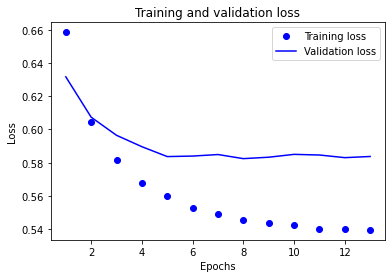

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

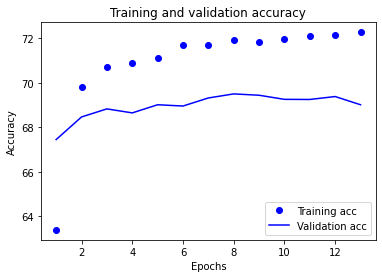

In [14]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

y_pred_list = []    # store predicted values for confusion matrix
y_target_list = []  # ground truth value

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    
    # store predicted values and ground truth values for calculating confusion matrix
    y_pred_list.extend((torch.sigmoid(y_pred)>0.5).cpu().long().numpy())
    y_target_list.extend(batch_dict['y_target'].cpu().numpy())
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [16]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.604
Test Accuracy: 67.85


In [17]:
rating_classes = []
for i in range(len(dataset._vectorizer.rating_vocab)):
    rating_classes.append(dataset._vectorizer.rating_vocab.lookup_index(i))
print(rating_classes)

['negative', 'positive']


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       negative  positive
Predicted                    
negative        558       277
positive        241       522


In [19]:
print(classification_report(y_target_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68       799
           1       0.68      0.65      0.67       799

    accuracy                           0.68      1598
   macro avg       0.68      0.68      0.68      1598
weighted avg       0.68      0.68      0.68      1598



### Inference

In [20]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [28]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = torch.sigmoid(result).item()
    print(probability_value)
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [37]:
test_review = "good story indeed"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

0.6052148938179016
good story indeed -> positive
